# Predição da intenção de compra

Neste trabalho iremos abordar o problema da predição da intenção de compra de um usuário tendo como apoio dados de sua navegação em uma sessão. Os dados utilizados provém do trabalho de Sakar et al. Utilizaremos a base baixada do repositório UCI, obtido pelo seguinte link: https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

## Importação de bibliotecas utilizadas

In [0]:
import pandas as pd

import seaborn as sns
sns.set()

# Exploração dos dados

A primeira parte será a exploração da base de dados para obter um conhecimento que permita propor transformações e análises sobre o conjunto.

In [0]:
dataset = pd.read_csv('/content/online_shoppers_intention.csv')

In [0]:
dataset.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Analisando o tipo de dados é possível notar que existem variáveis numéricas e categóricas.

In [0]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157213,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


Com o detalhamento do método _describe_, é possível observar algumas características do conjunto:
- Não possui valores nulos
- Talvez seja necessário realizar a normalização dos dados, pois existe alguma diferença de dimensão, principalmente no atributo ProductRelated_Duration.
- Nos atributos relacionados às páginas navegadas e permanência nas páginas, a variância parece ser bem elevada. Isso pode ser mais uma evidência favorável à normalização dos dados ou até mesmo a algum corte para eliminar possíveis outliers.
- Outra evidência é a medida de quartil. O terceiro quartil do campo Informational_Duration ainda tem valor 0.

Apesar de serem de tipo numérico e aparecerem no relatório do método _describe_, os atributos "OperatingSystems", "Browser", "Region" e "TrafficType" são, na verdade categóricos. Assim como os atributos Month, Weekend e Revenue, que por já possuírem tipo não numérico não apareceram no relatório acima.

A seguir, mostraremos os valores possíveis para as variáveis citadas no parágrafo anterior, para explicitar o seu tipo categórico.

In [0]:
dataset.OperatingSystems.unique()

array([1, 2, 4, 3, 7, 6, 8, 5])

In [0]:
dataset.Browser.unique()

array([ 1,  2,  3,  4,  5,  6,  7, 10,  8,  9, 12, 13, 11])

In [0]:
dataset.Region.unique()

array([1, 9, 2, 3, 4, 5, 6, 7, 8])

In [0]:
dataset.TrafficType.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18, 19,
       16, 17, 20])

In [0]:
dataset.VisitorType.unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [0]:
dataset.Weekend.unique()

array([False,  True])

In [0]:
dataset.Month.unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [0]:
dataset.Revenue.unique()

array([False,  True])

Vamos analisar agora os histogramas das variáveis. Como não são produzidos histogramas para variáveis não-numéricas, estamos aplicando uma transfomação nas colunas não-numéricas, afim de conseguir mostrar o histograma.

Essa transformação também será importante quando do treinamento dos modelos, já que trabalham melhor com valores numéricos.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f109fda8fd0>,
      dtype=object)

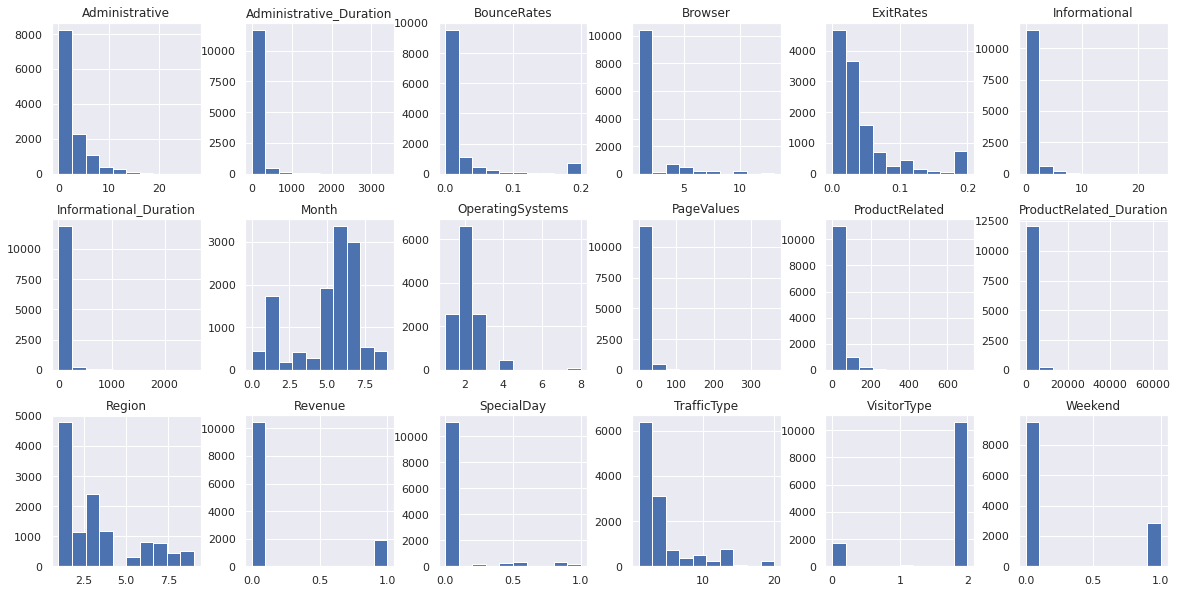

In [0]:
from sklearn.preprocessing import LabelEncoder

cols = ['Month', 'VisitorType', 'Weekend', 'Revenue']
encoder = LabelEncoder()

dataset = dataset.apply(lambda column: encoder.fit_transform(column) if column.name in cols else column)
dataset.hist(figsize=(20, 10), layout=(3, 6))

Como dito anteriormente, apesar de posuírem valores com intervalos grandes, a maior parte dos dados está concentrada em valores pequenos. É possível observar também que o conjunto de dados é desbalanceado, pois possui muito mais instâncias onde não houve compra. Por essa razão, podemos testar também a diferença de performance utilizando e não utilizando técnica de oversampling ou undersampling.

Vamos agora avaliar se existe algum tipo de correlação entre as variáveis, prestando atenção especial no atributo Revenue.

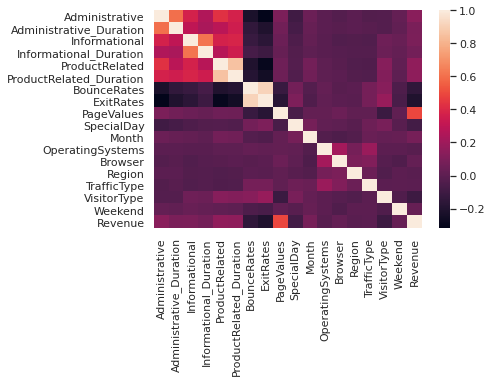

In [0]:
corr = dataset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Modelagem e resultados

Vamos utilizar a biblioteca sklearn para construir os modelos e treiná-los no conjunto de dados. Primeiramente sem qualquer tipo de modificação além das necessárias para que o modelo aceite, como por exemplo, transformar dados em números. Depois utilizaremos os mesmos conjuntos de treino e teste e os mesmo modelos, porém dessa vez com pré-processamento, para comparar os resultados.

## Sem pré-processamento

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [0]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=2000, random_state=42)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average='macro')
accuracy = accuracy_score(y_test, mlp_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 81.97%
precision: 70.56%
recall: 80.24%
f1: 73.14%


In [0]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, svc_pred, average='macro')
accuracy = accuracy_score(y_test, svc_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 84.30%
precision: 92.14%
recall: 50.51%
f1: 46.75%


In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, dt_pred, average='macro')
accuracy = accuracy_score(y_test, dt_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 85.27%
precision: 72.44%
recall: 72.66%
f1: 72.55%


In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')
accuracy = accuracy_score(y_test, rf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 89.75%
precision: 82.47%
recall: 76.24%
f1: 78.81%


In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, clf_pred, average='macro')
accuracy = accuracy_score(y_test, clf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 84.72%
precision: 71.37%
recall: 71.34%
f1: 71.36%


## Normalização

Nesta seção realizamos a normalização dos dados e verificamos sua influência sobre as medidas de desempenho dos modelos.

### StandardScaler

Este normalizador tem por objetivo transformar os valores dos atributos de modo que eles possuam média igual a zero e variância igual a 1, ou seja, os valores estarão contidos no intervalo [-1, 1].

In [0]:
from sklearn.preprocessing import StandardScaler

scaled_X = StandardScaler().fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=42)

In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=2000, random_state=42)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average='macro')
accuracy = accuracy_score(y_test, mlp_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 87.64%
precision: 77.25%
recall: 73.74%
f1: 75.28%


In [0]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, svc_pred, average='macro')
accuracy = accuracy_score(y_test, svc_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 88.55%
precision: 81.72%
recall: 70.38%
f1: 74.12%


In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, dt_pred, average='macro')
accuracy = accuracy_score(y_test, dt_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 85.50%
precision: 72.86%
recall: 73.13%
f1: 73.00%


In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')
accuracy = accuracy_score(y_test, rf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 89.75%
precision: 82.47%
recall: 76.24%
f1: 78.81%


In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, clf_pred, average='macro')
accuracy = accuracy_score(y_test, clf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 79.37%
precision: 67.19%
recall: 75.21%
f1: 69.21%


### Normalizer

Este normalizador tem por objetivo transformar os valores dos atributos de modo que eles possuam norma igual a 1, ou seja, todos os valores estarão contidos no intervalo [0, 1].

In [0]:
from sklearn.preprocessing import Normalizer

normalized_X = Normalizer().fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, random_state=42)

In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=2000, random_state=42)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average='macro')
accuracy = accuracy_score(y_test, mlp_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 89.00%
precision: 81.08%
recall: 74.13%
f1: 76.89%


In [0]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, svc_pred, average='macro')
accuracy = accuracy_score(y_test, svc_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 87.16%
precision: 85.39%
recall: 61.42%
f1: 64.90%


In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, dt_pred, average='macro')
accuracy = accuracy_score(y_test, dt_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 86.18%
precision: 74.11%
recall: 73.87%
f1: 73.99%


In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')
accuracy = accuracy_score(y_test, rf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 89.36%
precision: 82.10%
recall: 74.51%
f1: 77.49%


In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, clf_pred, average='macro')
accuracy = accuracy_score(y_test, clf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 33.18%
precision: 58.47%
recall: 59.38%
f1: 33.15%


## Feature selection

Este método de pré-processamento tem como objetivo eliminar da base de dados os atributos de menor influência na classificação dos modelos, ou seja, aqueles que apresentam a menor correção com os atributos de classe.
Este método de pré-processamento possui 3 principais vantagens:
- Reduzir o overfitting
- Melhorar a acurácia
- Reduzir o tempo de treinamento

Para isso utilizaremos o método SelectKBest da sklearn e selecionaremos os 10 melhores atributos da base de dados.

### Select K-Best (10 features)

In [0]:
from sklearn.feature_selection import SelectKBest

selected_X = SelectKBest().fit_transform(X, y)

print(X.shape)
print(selected_X.shape)

(12330, 17)
(12330, 10)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(selected_X, y, random_state=42)

In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=2000, random_state=42)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average='macro')
accuracy = accuracy_score(y_test, mlp_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 88.00%
precision: 78.79%
recall: 71.88%
f1: 74.55%


In [0]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, svc_pred, average='macro')
accuracy = accuracy_score(y_test, svc_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 84.30%
precision: 92.14%
recall: 50.51%
f1: 46.75%


In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, dt_pred, average='macro')
accuracy = accuracy_score(y_test, dt_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 84.69%
precision: 71.63%
recall: 73.31%
f1: 72.41%


In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')
accuracy = accuracy_score(y_test, rf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 89.69%
precision: 82.55%
recall: 75.70%
f1: 78.47%


In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, clf_pred, average='macro')
accuracy = accuracy_score(y_test, clf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 84.88%
precision: 71.62%
recall: 71.19%
f1: 71.40%


## Oversampling

Este método consiste em replicar a ocorrência de exemplos pertencentes à classe minoritária (neste caso, a classe positiva) com o objetivo de tornar o database mais balanceado e reduzir o erro atribuído à classe minoritária.

Faremos a transformação apenas no conjunto de treino para evitar que os conjuntos de treino e teste possuam exemplos iguais.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=2000, random_state=42)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average='macro')
accuracy = accuracy_score(y_test, mlp_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 87.38%
precision: 76.38%
recall: 81.22%
f1: 78.40%


In [0]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, svc_pred, average='macro')
accuracy = accuracy_score(y_test, svc_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 73.92%
precision: 64.39%
recall: 74.13%
f1: 65.08%


In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, dt_pred, average='macro')
accuracy = accuracy_score(y_test, dt_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 85.99%
precision: 73.70%
recall: 72.26%
f1: 72.94%


In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')
accuracy = accuracy_score(y_test, rf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 89.26%
precision: 79.90%
recall: 79.85%
f1: 79.87%


In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, clf_pred, average='macro')
accuracy = accuracy_score(y_test, clf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 81.54%
precision: 68.80%
recall: 75.51%
f1: 70.95%


## Undersampling

Este método é análogo ao Oversampling, com a diferença que neste caso o objetivo é excluir do database alguns exemplos pertencentes à classe majoritária (neste caso, a negativa) a fim de tornar o database mais balanceado.

In [0]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=42)
X_resampled, y_resampled = cc.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=2000, random_state=42)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average='macro')
accuracy = accuracy_score(y_test, mlp_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 71.91%
precision: 72.68%
recall: 71.68%
f1: 71.52%


In [0]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, svc_pred, average='macro')
accuracy = accuracy_score(y_test, svc_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 62.89%
precision: 63.13%
recall: 63.01%
f1: 62.84%


In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, dt_pred, average='macro')
accuracy = accuracy_score(y_test, dt_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 80.08%
precision: 80.10%
recall: 80.11%
f1: 80.08%


In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')
accuracy = accuracy_score(y_test, rf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 85.32%
precision: 85.45%
recall: 85.25%
f1: 85.29%


In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, clf_pred, average='macro')
accuracy = accuracy_score(y_test, clf_pred)

print(f'accuracy: {accuracy:.2%}')
print(f'precision: {precision:.2%}')
print(f'recall: {recall:.2%}')
print(f'f1: {f1:.2%}')

accuracy: 76.52%
precision: 76.55%
recall: 76.46%
f1: 76.48%
